In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import re
from collections import Counter
import os
import sys
import joblib
sys.path.insert(0, os.path.abspath(os.path.join(".", "transformers")))
from preprocessing import * 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import cartopy.crs as ccrs
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from math import radians, sin, cos, sqrt, asin

In [2]:
df = pd.read_csv('dataframes/google_places_data.csv')

<span style="color:orange;">Dla grupy walidacyjnej: sprawdzając używajcie ramki test_df w miejscach, gdzie jest val_df</span>

In [3]:
train_df, test1_df = train_test_split(df, test_size=0.3, random_state=42)

test_df, val_df= train_test_split(test1_df, test_size=0.4, random_state=42)

# First clustering - geo clusters

In this part we will focus on clustering our data based only on their latitude and longitude. To achieve that we will create a custom distance function to inclue the Earth's curve.

Then we will save the results to csv and use it as a new dataframe in further clustering in another file

# Feature engineering

In this part we will focus on:
* dealing with missing data 
* normalizing numerical features
* selecting relevant columns and deleting columns with potential mistakes
* adding new features

In [4]:
#checking for missing values
def check_for_missing(df):
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        print("Missing values in column: ", column, "=", missing_count)

check_for_missing(train_df)

Missing values in column:  business_id = 0
Missing values in column:  phone_number = 0
Missing values in column:  name = 0
Missing values in column:  full_address = 0
Missing values in column:  latitude = 5
Missing values in column:  longitude = 5
Missing values in column:  review_count = 0
Missing values in column:  rating = 0
Missing values in column:  timezone = 0
Missing values in column:  website = 0
Missing values in column:  place_id = 0
Missing values in column:  place_link = 0
Missing values in column:  types = 0
Missing values in column:  Friday = 0
Missing values in column:  Saturday = 0
Missing values in column:  Sunday = 0
Missing values in column:  Monday = 0
Missing values in column:  Tuesday = 0
Missing values in column:  Wednesday = 0
Missing values in column:  Thursday = 0
Missing values in column:  city = 0
Missing values in column:  verified = 0
Missing values in column:  state = 0
Missing values in column:  Friday_morning = 0
Missing values in column:  Friday_after

We have only 5 missing values in columns latitude, longitude, geo_cluster, 
but there are also "hidden" missing values like "Unknown" in website, phone number etc

In [4]:
train_df[train_df['latitude'].isna() | train_df['longitude'].isna()] #missing values in latitude and longitude

,business_id,phone_number,name,full_address,latitude,longitude,review_count,rating,timezone,website,...,Tuesday_afternoon,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,geo_cluster,country
5368,0x549175bad87e4499:0xe474185a7c812203,13608880460,IJB Painting Company,Unknown,NaN,NaN,32.0,4.4,America/Los_Angeles,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
5355,0x80dd4a6f6bc3c0d1:0xa0dbcc9e52e67a7d,13105300994,"R Painting,License #752512",Unknown,NaN,NaN,32.0,4.4,America/Los_Angeles,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
12398,0x886b5c66fee9323d:0x3aa2c26684beba68,18137481822,Election Roofing and Construction LLC,Unknown,NaN,NaN,1.0,4.0,America/New_York,https://election-roofing-and-construction-llc....,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
7683,0x3e5f43a21c43cf97:0x5ab0bd09eee41976,971524175130,S&Y Travel Agency,Unknown,NaN,NaN,32.0,4.4,Asia/Dubai,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
8571,0xb2afb323ceda5e5:0x9616560c124aa170,971509014567,Luxury District Real Estate,Unknown,NaN,NaN,32.0,4.4,Asia/Dubai,Unknown,...,1,1,1,1,1,1,1,1,NaN,United Arab Emirates


Now we will create groups from 'types' column, for that we used ChatGPT to determine some of the most important and often present categories, then we classify using Regex 

In [5]:
#checking for keywords in 'types' column
keywords=[]
for line in train_df['types'].unique():  
    if pd.notna(line):
        words = re.findall(r'\b\w+\b', line.lower())
        keywords.extend(words)

word_counts = Counter(keywords)
print(word_counts)


Counter({'store': 1771, 'service': 1181, 'shop': 622, 'restaurant': 619, 'dealer': 468, 'agency': 452, 'car': 424, 'repair': 302, 'clothing': 295, 'auto': 291, 'attorney': 289, 'clinic': 255, 'center': 253, 'tourist': 235, 'dental': 233, 'estate': 221, 'supplier': 218, 'attraction': 213, 'park': 207, 'jewelry': 205, 'real': 204, 'bar': 196, 'contractor': 181, 'used': 181, 's': 180, 'and': 179, 'furniture': 171, 'dentist': 170, 'pet': 165, 'hotel': 161, 'tour': 156, 'insurance': 149, 'museum': 144, 'company': 142, 'home': 134, 'designer': 124, 'school': 119, 'consultant': 119, 'law': 115, 'office': 109, 'medical': 109, 'salon': 108, 'church': 103, 'cafe': 98, 'bakery': 97, 'establishment': 97, 'rental': 96, 'supply': 95, 'coffee': 92, 'club': 91, 'flower': 91, 'beauty': 90, 'delivery': 89, 'painter': 88, 'maintenance': 82, 'venue': 79, 'firm': 78, 'art': 78, 'care': 77, 'hair': 75, 'health': 75, 'hospital': 74, 'accessories': 73, 'physical': 73, 'shoe': 72, 'cleaning': 72, 'interior': 6

In [6]:
# determined categories
main_categories = ["Hotel","Restaurant","Shop","Service","Agency","Dealer","Repair","Car","Travel","Fitness","Health","Dental","RealEstate",
    "Office","Tourist","Attraction","Park","Attorney","Bank","Pharmacy","Supermarket","Bakery","Barbershop","Hospital","Library","Museum","Cinema",
    "Store","Jeweler","Beauty"
]

All necessary dataframe transformations are in preprocessing.py transformers. What we did was:

* Remove rows with missing geographical coordinates
* Add new binary columns 1- phone/website is known and 0 if else
* We classified each row to categories given above detected by ChatGPT
* We removed columns we found irrelevant like :
1) business_id, phone numer, website, full address - as every company has a unique value
2) geographical related columns like cuntry, city, timezone, place_id etc as we found many misleading information in EDA and we will perform custom location clustering
* We standardized relevant numerical columns like rating and review count

Further feature engineering will be added for second part of clustering

**Here is our data after all transformations:**

In [7]:
processing_pipeline = Pipeline([
    ('missing_location_remover', MissingGeographRemover()),
    ('contact_adder', ContactKnownAdder()),
    ('group', ClassifyType()),
    ('irrelevant_remove', IrrelevantColumnRemover()),
    ('feature_scale', NumericalStandardizer())])

joblib.dump(processing_pipeline, 'pipelines/preprocessing_pipeline.joblib') # file that we can load from different scripts

train_df=processing_pipeline.fit_transform(train_df)
val_df = processing_pipeline.transform(val_df)
train_df.head(3)

,name,latitude,longitude,review_count,rating,Friday,Saturday,Sunday,Monday,Tuesday,...,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,Website_known,Phone_known,main_category
656,Lead Handyman Services,25.324796,55.417346,-0.135231,1.061147,8-11 AM,8 AM-6 PM,8 AM-6 PM,8 AM-6 AM,8 AM-6 PM,...,0,0,0,0,0,0,0,1,1,Service
3254,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,-0.136699,1.061147,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,0,1,1,Attorney
8116,Action,52.186431,5.293758,0.064644,-0.280588,8:30 AM-9 PM,8:30 AM-6 PM,10 AM-6 PM,8:30 AM-8 PM,8:30 AM-8 PM,...,0,0,0,0,0,0,0,1,1,Shop


# Geo Clustering 
We already have a column geo_cluster, but it does not provide us enough information and is rather not using Earth's curvature. Let's check if w can get more!

#### Definitions of Haversine and other functions

In [15]:
# def plot_world(color_column, coord_df):
#   fig, ax = plt.subplots(figsize=(15, 6),
#   subplot_kw={'projection': ccrs.PlateCarree()})
#   ax.coastlines()
#   sc = ax.scatter(coord_df['longitude'],
#   coord_df['latitude'],c=coord_df[color_column], s=1,
#   cmap='viridis', transform=ccrs.PlateCarree())
#   ax.set_title('World Map with ' + f'{color_column}')
#   plt.show()

import matplotlib.colors as mcolors

def plot_world(color_column, coord_df):
    fig, ax = plt.subplots(figsize=(15, 6),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    cmap = plt.get_cmap('viridis')
    
    # Normalize color column values to fit colormap range
    norm = mcolors.Normalize(vmin=coord_df[color_column].min(), vmax=coord_df[color_column].max())
    
    # Scatter plot
    sc = ax.scatter(coord_df['longitude'],
                    coord_df['latitude'], c=coord_df[color_column], s=1,
                    cmap='viridis', norm=norm, transform=ccrs.PlateCarree())
    ax.set_title('World Map with ' + f'{color_column}')
    
    # Create a legend manually
    unique_values = sorted(coord_df[color_column].unique())
    for value in unique_values:
        ax.scatter([], [], c=[cmap(norm(value))], label=f'{value}')
    
    # Add the legend to the plot
    ax.legend(title=color_column)
    plt.show()

Since sklearn does not allow use haversine distance as measure, we have to write our custome distance function and a clustering class with standard methods implemented.

In [9]:
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Custom KMeans class
class HaversineKMeans:
  def __init__(self, n_clusters, max_iter=300, tol=1e-4):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.tol = tol
    self.cluster_centers_ = None

  def fit(self, X):
    n_samples = X.shape[0]

    # Initialize centroids randomly
    np.random.seed(50)
    initial_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
    self.cluster_centers_ = X[initial_indices]

    for i in range(self.max_iter):
      # Compute distances using Haversine formula
      distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                            for lat2, lon2 in self.cluster_centers_] 
                            for lat1, lon1 in X])

      # Assign clusters
      labels = np.argmin(distances, axis=1)

      # Compute WCSS during each iteration
      wcss = 0
      for i in range(n_samples):
        wcss += distances[i, labels[i]]**2

      # Update centroids
      new_centers = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])

      # Check for convergence
      if np.all(np.abs(new_centers - self.cluster_centers_) < self.tol):
        break

      self.cluster_centers_ = new_centers

  def predict(self, X):
    distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                          for lat2, lon2 in self.cluster_centers_] 
                          for lat1, lon1 in X])
    return np.argmin(distances, axis=1)


  def wcss(self):
    if not hasattr(self, 'cluster_centers_'):
      raise ValueError("Model not fitted yet. Call 'fit' before calculating WCSS.")
    
    n_samples = X.shape[0]
    distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                          for lat2, lon2 in self.cluster_centers_] 
                          for lat1, lon1 in X])
    labels = np.argmin(distances, axis=1)
    
    wcss = 0
    for i in range(n_samples):
      wcss += distances[i, labels[i]]**2
    return wcss


### First geo clustering 

In [10]:
wcss = []

ll_train_df1 = train_df[['latitude','longitude']]
X = ll_train_df1[['latitude', 'longitude']].values

for k in range(2,14):
    kmeans = HaversineKMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.wcss()) 

Now let's see which number of cluster should be optimal for us using the elbow method.

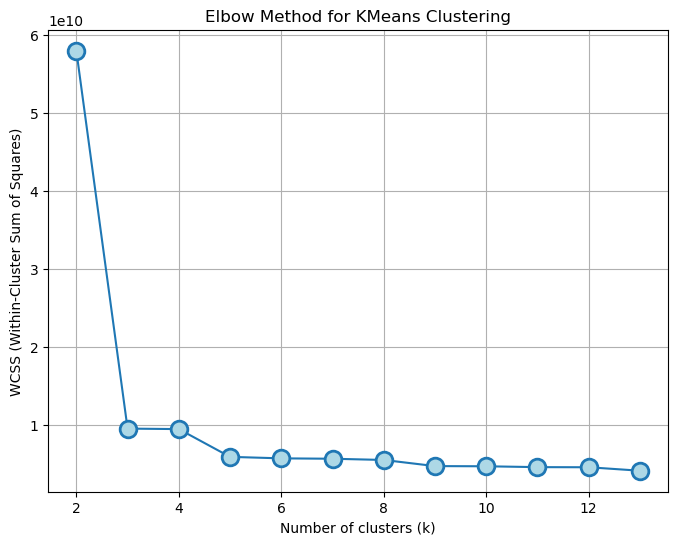

In [12]:
plt.figure(figsize=(8, 6))
krange = list(range(2,14))
plt.plot(krange, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=12)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()

There is an obvious decline in WCSS after the 3rd and 4th clusters, but this is not enough for us (these numbers of clusters does not even distinguish East and West USA), so we can check where is the second major decline, and its in the number of clusters is bigger. Let's create 2 possible variants for our clusters.

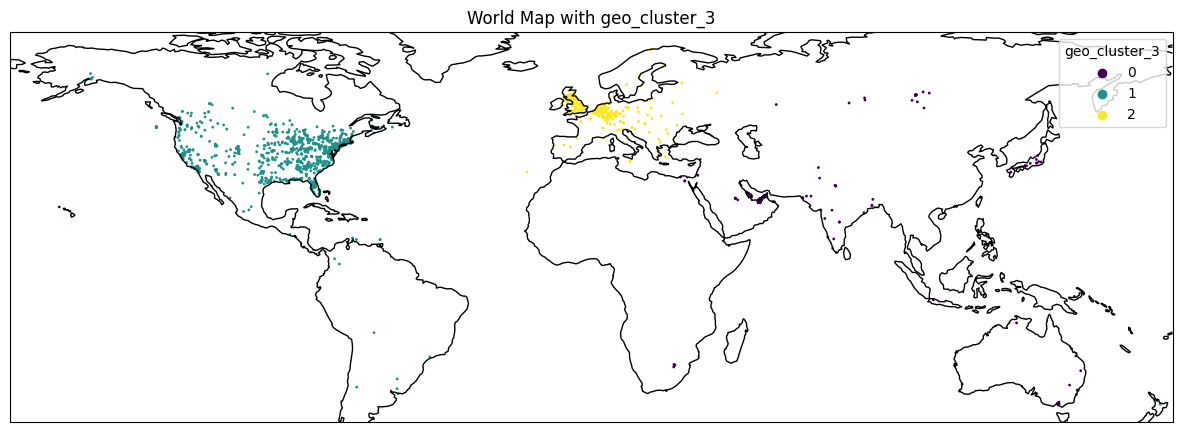

In [16]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=3)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_3'] = kmeans.predict(X)
plot_world('geo_cluster_3',ll_train_df1)

We can see 3 clusters is too few for our data

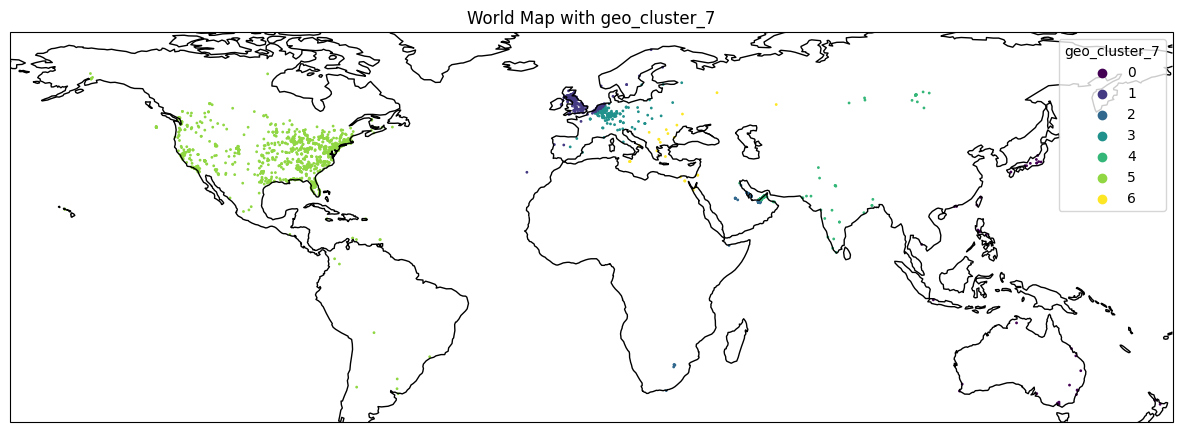

In [17]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=7)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_7'] = kmeans.predict(X)
plot_world('geo_cluster_7',ll_train_df1)

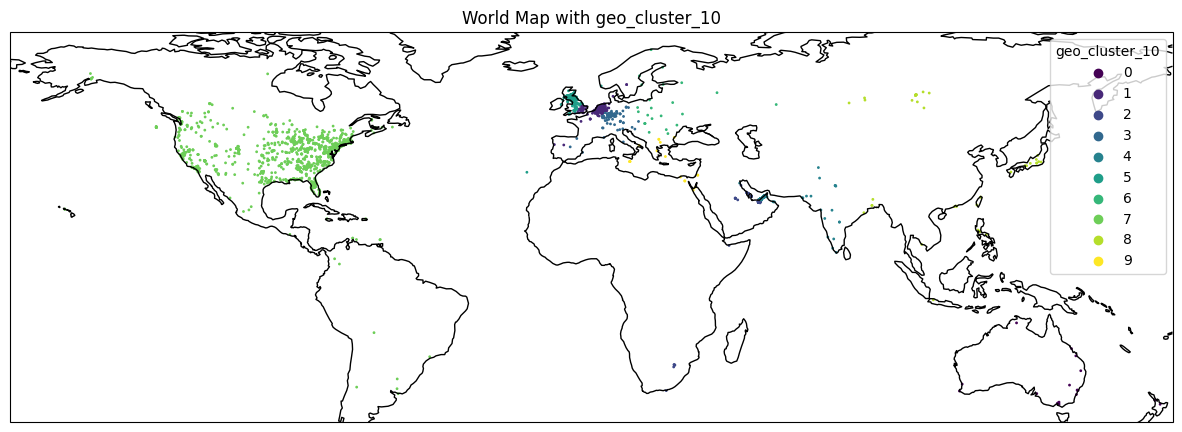

In [18]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=10)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_10'] = kmeans.predict(X)
plot_world('geo_cluster_10',ll_train_df1)

Increasing the number of clusters for KMeans does not show the desired result, so let's focus on hierarchical clustering

#### Hierarchical clustering 

Now let's try to perform hierarchical clustering of the clusters with the biggest number of entries that are concentrated in one part of the world (North America and Europe). The dataframe with raw data can be passed into geo_clustering function and will be clustered based on the train_df.

In [19]:
def geo_clustering(data1):
    train_copy = train_df.copy(deep=True)
    data = data1.copy(deep=True)
    ll_df1 = train_df[['latitude','longitude']]
    X = train_df[['latitude','longitude']].values
    
    ll_data = data[['latitude','longitude']]
    pX = data[['latitude','longitude']].values
    
    # Perform clustering
    kmeans = HaversineKMeans(n_clusters=3)
    kmeans.fit(X)

    # Assign 3 clusters
    data['geo_cluster_3'] = kmeans.predict(pX)
    train_copy['geo_cluster_3'] = kmeans.predict(X)
    
    cl2 = data[data['geo_cluster_3'] == 2]
    cl1 = data[data['geo_cluster_3'] == 1]
    
    train_cl2 = train_copy[train_copy['geo_cluster_3'] == 2]
    train_cl1 = train_copy[train_copy['geo_cluster_3'] == 1]

    X2 = cl2[['latitude', 'longitude']].values
    X1 = cl1[['latitude', 'longitude']].values
    
    train_X2 = train_cl2[['latitude', 'longitude']].values
    train_X1 = train_cl1[['latitude', 'longitude']].values
    
    # Europe clustering - start
    kmeans = HaversineKMeans(n_clusters=2)
    kmeans.fit(train_X2)
    
    # Assign clusters
    cl2['geo_cluster'] = kmeans.predict(X2)
    cl2.loc[cl2['geo_cluster'] == 0, 'geo_cluster'] = 2
    # Europe clustering - finish
    
    # America clustering - start
    kmeans = HaversineKMeans(n_clusters=3)
    kmeans.fit(train_X1)
    
    # Assign clusters
    cl1['geo_cluster'] = kmeans.predict(X1)
    cl1.loc[cl1['geo_cluster'] == 0, 'geo_cluster'] = 3
    cl1.loc[cl1['geo_cluster'] == 1, 'geo_cluster'] = 4
    cl1.loc[cl1['geo_cluster'] == 2, 'geo_cluster'] = 5
    # America clustering - finish
    
    cl1 = cl1[['latitude', 'longitude','geo_cluster']]
    cl2 = cl2[['latitude', 'longitude','geo_cluster']]

    cl3 = data[data['geo_cluster_3']==0]
    cl3 = cl3.rename(columns={'geo_cluster_3': 'geo_cluster'})
    cl3 = cl3[['latitude', 'longitude','geo_cluster']]

    merged_df = pd.concat([cl1, cl2, cl3], ignore_index=True)
    data = pd.merge(data, merged_df, on=['longitude', 'latitude'])
    data = data.drop(columns=['geo_cluster_3'])
    return data
    
    

Final result after hierarchical clustering

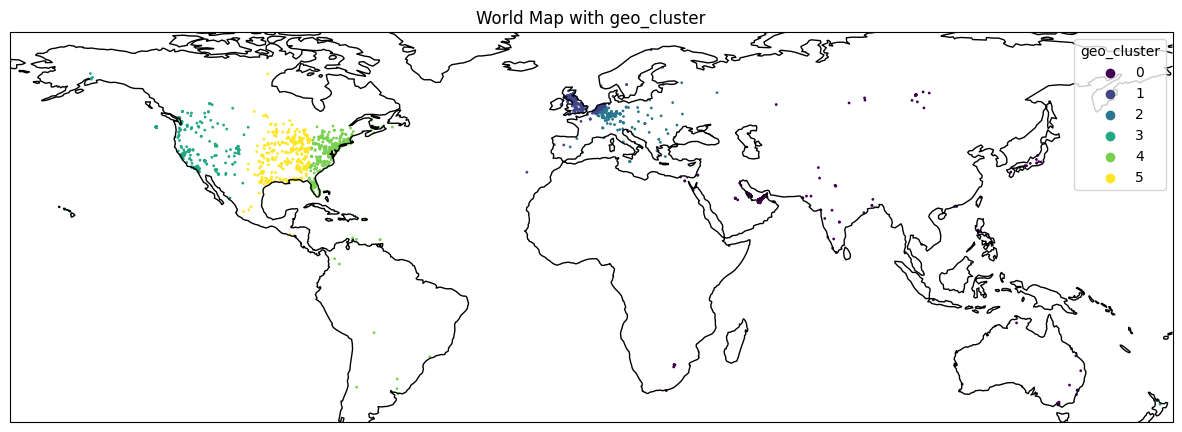

In [20]:
train_geo_clustered = geo_clustering(train_df) # final clusters for train df
plot_world('geo_cluster',train_geo_clustered)

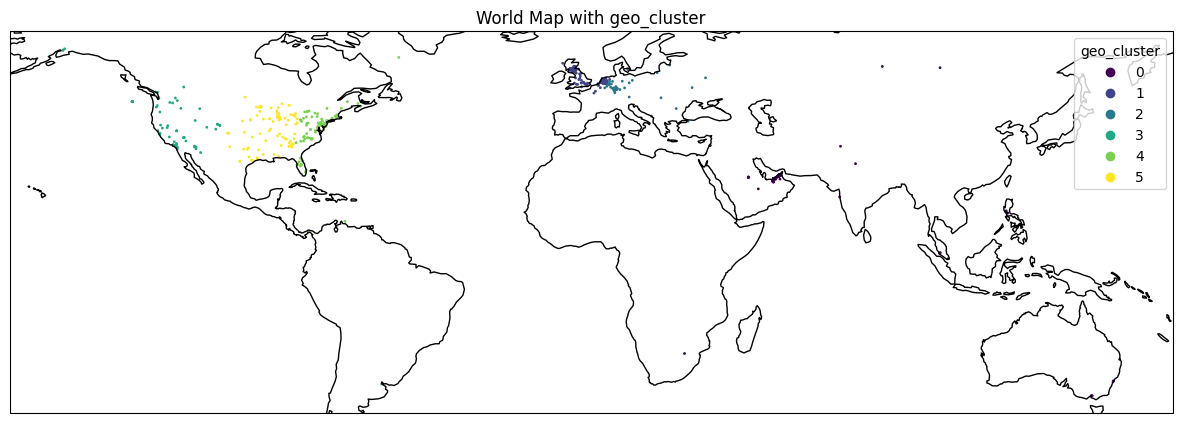

In [22]:
val_geo_clustered = geo_clustering(val_df) # also for validation df
plot_world('geo_cluster',val_geo_clustered)

In [19]:
# save a new df as csv
train_geo_clustered.to_csv('dataframes/train_geo_clustered.csv', index=False)
val_geo_clustered.to_csv('dataframes/val_geo_clustered.csv', index = False)